# Prior estimation

In [1]:
using MAT
include("../src/ObjectiveEmpiricalBayes.jl")
OPTCONFIG=OptConfig(XTOLREL=1e-5, XTOLABS=1e-5, DEBUG=true);

In [2]:
using MAT
function plt2mat(p, filename)
    d = [(filter(isalpha, l[:get_label]()), hcat(l[:get_data]()...)) for a in p[:axes] for l in a[:lines] ] |> Dict
    matwrite(filename, d)
end

plt2mat (generic function with 1 method)

In [3]:
# enable pyplot-latex
PyCall.PyDict(PyPlot.matplotlib["rcParams"])["text.usetex"] = true

true

## The Model

In [4]:
# exponential
xlims = (0,220)
n = 100 # was 500
ndata = 60
σ = 8
#prior = Truncated(MixtureModel([Normal(mu, .5) for mu in [1, 3]]), xlims...)
prior = Truncated(MixtureModel([Normal(60, 15), Normal(160,15)], [0.3, 0.7]), xlims...)

t    = Transformation(x->exp(x/70), x->log(x)*70)

Transformation(#88, #89)

In [5]:
randseed=90
srand(randseed)
#srand(2)
m = FEModel(f=x->.45*x, xs=linspace(xlims...,n), σ=σ)
#d = generatedata(m, prior, ndata);
d = matread("../zMeas60.mat")["zMeas"]|> vec
mt   = transformmodel(m, t)

FEModel(ft, 1.0:0.22393911412386341:23.16997229826248, 8)

In [6]:
ncv = 20
kfold = length(d);

In [7]:
lims = ([0,220],[0,.025],[1,exp(220/70)], [0,0.4])

([0, 220], [0.0, 0.025], [1.0, 23.17], [0.0, 0.4])

## Results

In [8]:
figsize=(4*0.8,3*0.8*0.8)

(3.2, 1.9200000000000004)

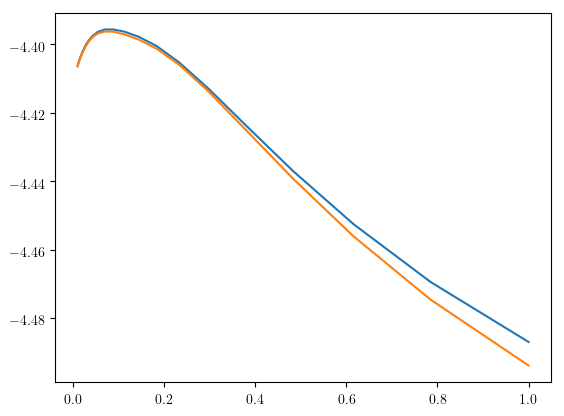

(regr.γ, maximum(cvs)) = (0.06951927961775606, -4.395714905287859)


In [20]:
gammas = logspace(-2,0,ncv)
regr,  cvs  = cvreference(m,  d, gammas, c=OPTCONFIG)
regrt, cvst = cvreference(mt, d, gammas, c=OPTCONFIG)
@assert regr.γ == regrt.γ
@show regr.γ, maximum(cvs)
plot(gammas, [cvs cvst]);

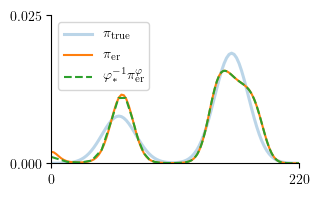

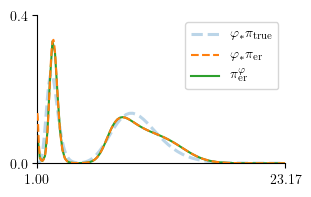

In [12]:
wR  = ebprior(m,  d, regr,  OPTCONFIG)
wRt = ebprior(mt, d, regrt, OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wR, wRt, "er", lims...; figsize=figsize, savename="eb$randseed")

plt2mat(p1, "er.mat")
plt2mat(p2, "erT.mat")

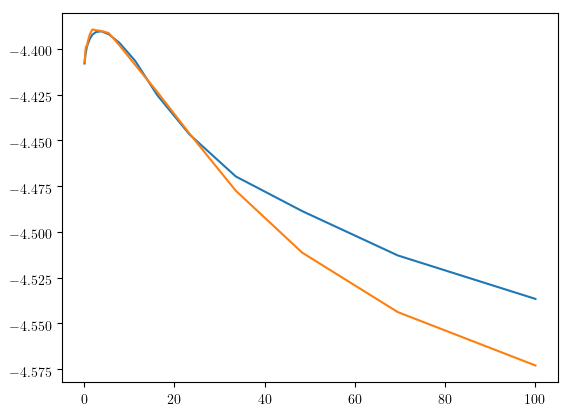

map(maximum, [ss, sst]) = [-4.39038, -4.38939]
regT = regs[indmax(ss)].γ = 3.79269019073225
regTt = regs[indmax(sst)].γ = 1.8329807108324359


1.8329807108324359

In [24]:
## thik estimator
regs = [ThikonovRegularizer(γ) for γ in logspace(-1,2,ncv)]
ss = [cvscore(m, d, d->ebprior(m, d, r, OPTCONFIG), kfold) for r in regs]
sst = [cvscore(mt, d, d->ebprior(mt, d, r, OPTCONFIG), kfold) for r in regs]

plot([r.γ for r in regs], [ss sst])
@show map(maximum, [ss,sst])
@show regT  = regs[indmax(ss )].γ
@show regTt = regs[indmax(sst)].γ

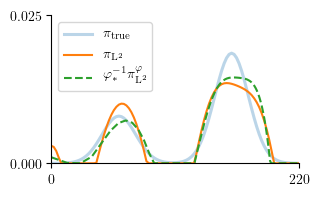

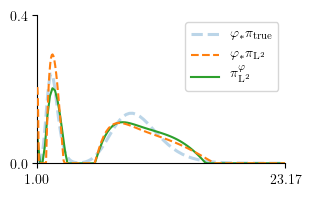

In [23]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTto = ebprior(mt, d, ThikonovRegularizer(regT), OPTCONFIG)

p1,p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTto, "L^2", lims...; figsize=figsize, savename="l2gammafix$randseed")

plt2mat(p1, "l2.mat")
plt2mat(p2, "l2T.mat")

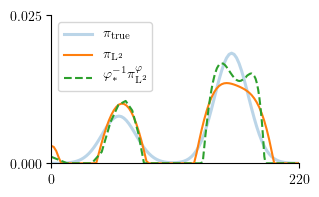

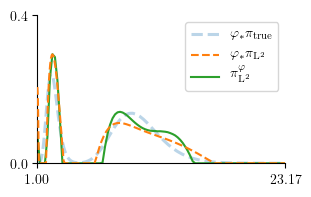

(PyPlot.Figure(PyObject <Figure size 320x192 with 1 Axes>), PyPlot.Figure(PyObject <Figure size 320x192 with 1 Axes>))

In [15]:
wT = ebprior(m,  d, ThikonovRegularizer(regT), OPTCONFIG)
wTt = ebprior(mt, d, ThikonovRegularizer(regTt), OPTCONFIG)

p1, p2 = compareplot(m, t, pdf.(prior, m.xs), wT, wTt, "L^2", lims...; figsize=figsize, savename="l2$randseed")